# ANALYZING & FORECASTING GROSS DOMESTIC PRODUCT (GDP) TRENDS

# (Case Study - Kenya)

## Introduction

Kenyan Parliament recently, on the 26th June 2023, passed to law the contentious Finance Bill 2023 proposing a raft of tax policy measures which aim to yield additional revenue and explore more effective measures to enhance Country's revenue collection.

The House argued that, in comparison to other comparable African countries’ Tax revenue as a percentage of Gross Domestic Product (GDP) like Botswana’s 24 percent, Mauritius’ 18 percent and Zambia’s 17 percent, Kenya was falling behind in terms of tax revenue collection at 13 percent as at 2021. The mentioned countries have since managed to achieve higher tax revenue collection rates thus highlighting the need to reassess Country's tax policies and explore more effective measures to enhance revenue collection.

The Government feels the ratio of tax revenue as a percentage of Gross Domestic Product (GDP) being well below acceptable levels to enable spur economic growth & reduce cost of living in the long term. **`(According to the World Bank, tax revenues above 15% of a country’s GDP are a key ingredient for economic growth and, ultimately, poverty reduction)`**

Taxes are a critical measure of a nation’s development and governance. The tax-to-GDP ratio is used to determine how well a nation's government directs its economic resources. Higher tax revenues mean a country is able to spend more on improving infrastructure, health, and education—keys to the long-term prospects for a country’s economy and people.

Some of the questions a taxpayer might ask based on the proposed bill might include:

> **Is GDP level growing proportionately to the projected tax revenue collections to enable government meet its target?**

> **What are the alternatives or other focus areas in case government fails to meet its tax projections?**

Policymakers use the tax-to-GDP ratio to compare tax receipts from year to year because it offers a better measure of the rise and fall in tax revenue than simple amounts.

Hence GDP becomes a critical factor to explore, predict and assist determine if the country is in line to achieve its bold aspirations within the next 3-4 years as committed.

## Business Understanding

The tax-to-GDP ratio is a measure of a nation's tax revenue relative to the size of its economy. GDP is a vital economic indicator that reflects the overall economic performance of countries and guides policy-making, investment decisions, and strategic planning.

>***Project shall aim to analyse Country's historical GDP trends and forecast future GDP growth. The analysis shall assist provide insights into economic growth patterns, identify emerging trends, and support evidence-based decision-making for various stakeholders.***

## Data Understanding & Preparation

Data downloaded from The World Bank website database (https://datatopics.worldbank.org/world-development-indicators) and saved remotely for preprocessing. Our target variable (GDP) & other features/indicators columns collected over a period of time explained as below: Daily data aggregated (Weighted average aggregation method); annualized & expressed in U.S. Dollars for each period unless stated otherwise.

- **Year**: Annual periodicity (62 year trend analysis obtained between 1960 & 2022)
- **GDP**: Gross Domestic Product
- **Exports**: Total transactions value in goods and services from residents to non-residents
- **Imports**: Total transactions value in goods and services from non-residents to residents.
- **ExchRate**: Exchange Rate - Local currency per U.S. Dollar period average expressed in National Currency Unit
- **InfRte**: Inflation Rate
- **Population**: Total Population of a country
- **TaxRev**: Total tax revenue collected.
- **LbrFrce**: Labor Force
- **UnEmpRte**: Unemployment Rate
- **EmpRte**: Employment Rate
- **GrossDomSavg**: Gross Domestic Savings
- **GrossConsump**: Gross Consumption/Expenditure
- **IntPen**:Individuals using the Internet (% of population): Internet Penetration Rate
- **AgriOutput**: Agriculture, forestry, and fishing, value added; generally focuses on production or manufacturing processes, marketing or services that increase the value of primary agricultural commodities

Noting that Time Series Analysis Models work on Uni-variate data; and for a deeper mastering of topic at hand; we shall go an extra step to explore all the columns & their relationships, with our predictor/target variable (GDP) & with each other.

In [1]:
#Importing necessary libraries
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
import itertools
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib
sns.set(style="ticks", color_codes=True)
#sns.set_style("whitegrid")

Data Loading & changing the year in our dataset from "non-null object" to "non-null datetime" (i.e., change the data type of dates)and setting as index

In [2]:
#Importing & loading dataset
df = pd.read_csv('Timeseries_Data.csv')
#Convert Year to a datetime column
df['Year'] = pd.to_datetime(df['Year'])
# Make Year the index
df.set_index('Year', inplace=True)
#visualizing top rows of our dataset
df.head(3)

<ipython-input-2-365e1733c48e>:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Year'] = pd.to_datetime(df['Year'])


,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte
Year,,,,,,,,,,,,,,
1960-12-31,"6,102,055,383",NaN,"7,751,435","246,049,901","266,419,907","135,645,848",NaN,"279,691,874",NaN,7.14,1.24%,NaN,NaN,NaN
1961-12-31,"5,627,642,856",NaN,"8,047,470","259,433,896","246,847,901","133,041,863",NaN,"270,185,892",NaN,7.14,2.46%,NaN,NaN,NaN
1962-12-31,"6,159,869,229",NaN,"8,363,578","278,123,875","261,519,895","142,939,845",NaN,"326,185,869",NaN,7.14,3.12%,NaN,NaN,NaN


**`ExchRate`** column currency is in National Loacal Currency (Kenya Shilling) while the other column values expresed in U.S. Dollars. For consistency, we shall create a new calculated column **`ExcRate`** that shall take this into consideration and proceed to drop initial column.

In [3]:
#creating new column
df['ExcRate'] = round ((1 / df['ExchRate']),2)
#dropping `ExchRate` column
df.drop(['ExchRate'], axis=1)
#view top rows
df.head(3)

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte,ExcRate
Year,,,,,,,,,,,,,,,
1960-12-31,"6,102,055,383",NaN,"7,751,435","246,049,901","266,419,907","135,645,848",NaN,"279,691,874",NaN,7.14,1.24%,NaN,NaN,NaN,0.14
1961-12-31,"5,627,642,856",NaN,"8,047,470","259,433,896","246,847,901","133,041,863",NaN,"270,185,892",NaN,7.14,2.46%,NaN,NaN,NaN,0.14
1962-12-31,"6,159,869,229",NaN,"8,363,578","278,123,875","261,519,895","142,939,845",NaN,"326,185,869",NaN,7.14,3.12%,NaN,NaN,NaN,0.14


Removing special characters in dataset: We shall remove all commas (,) and percentage signs (%) from dataframe & progress to convert data types from object to numeric.

In [4]:
#removing all commas from dataframe
df.replace(',','', regex=True, inplace=True)
#removing all % sign from dataframe
df.replace('%','', regex=True, inplace=True)
#visualizing top rows of our dataset
df.head()

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte,ExcRate
Year,,,,,,,,,,,,,,,
1960-12-31,6102055383,NaN,7751435,246049901,266419907,135645848,NaN,279691874,NaN,7.14,1.24,NaN,NaN,NaN,0.14
1961-12-31,5627642856,NaN,8047470,259433896,246847901,133041863,NaN,270185892,NaN,7.14,2.46,NaN,NaN,NaN,0.14
1962-12-31,6159869229,NaN,8363578,278123875,261519895,142939845,NaN,326185869,NaN,7.14,3.12,NaN,NaN,NaN,0.14
1963-12-31,6700603507,NaN,8697200,296813881,268365892,148343815,NaN,356271857,NaN,7.14,0.70,NaN,NaN,NaN,0.14
1964-12-31,7033252776,NaN,9047387,333479880,291759883,172199777,957039518,367863839,NaN,7.14,-0.10,NaN,NaN,NaN,0.14


Checking dataframe for any duplicate rows.

In [5]:
#Checking for any duplicated rows
dup_rows = df[df.duplicated()]
print("Number of Duplicates:", df.duplicated().sum())

Number of Duplicates: 0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 1960-12-31 to 2022-12-31
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GDP           63 non-null     object 
 1   TaxRev        9 non-null      object 
 2   Population    63 non-null     object 
 3   Exports       63 non-null     object 
 4   Imports       63 non-null     object 
 5   GrossDomSavg  63 non-null     object 
 6   GrossConsump  59 non-null     object 
 7   AgriOutput    63 non-null     object 
 8   LbrFrce       33 non-null     object 
 9   ExchRate      63 non-null     float64
 10  InfRte        63 non-null     object 
 11  IntPen        31 non-null     object 
 12  UnEmpRte      32 non-null     float64
 13  EmpRte        32 non-null     float64
 14  ExcRate       63 non-null     float64
dtypes: float64(4), object(11)
memory usage: 7.9+ KB


> **Dataset contains 14 coulmns columns of interest with 4 columns having numeric data types (float4) & the remaining having 11 appearing as string data types (object). We need to convert all columns to numeric to enable us perform statistical analysis of our dataset**

Converting object to numeric data types: This shall enable us to check the overall statistics about our dataset

In [7]:
#creating a dataframe containiing only string dtypes & converting them to numeric
cols = df.columns.drop(['ExchRate','UnEmpRte','EmpRte','ExcRate'])
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [8]:
#checking our new data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 1960-12-31 to 2022-12-31
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GDP           63 non-null     int64  
 1   TaxRev        9 non-null      float64
 2   Population    63 non-null     int64  
 3   Exports       63 non-null     int64  
 4   Imports       63 non-null     int64  
 5   GrossDomSavg  63 non-null     int64  
 6   GrossConsump  59 non-null     float64
 7   AgriOutput    63 non-null     int64  
 8   LbrFrce       33 non-null     float64
 9   ExchRate      63 non-null     float64
 10  InfRte        63 non-null     float64
 11  IntPen        31 non-null     float64
 12  UnEmpRte      32 non-null     float64
 13  EmpRte        32 non-null     float64
 14  ExcRate       63 non-null     float64
dtypes: float64(9), int64(6)
memory usage: 7.9 KB


> **All columns now appearing as numeric variables**

In [9]:
#checking for unique values in columns
df.nunique()

GDP             63
TaxRev           9
Population      63
Exports         63
Imports         63
GrossDomSavg    63
GrossConsump    59
AgriOutput      63
LbrFrce         33
ExchRate        50
InfRte          62
IntPen          28
UnEmpRte        29
EmpRte          32
ExcRate         13
dtype: int64

> ***Overall summary of our dataset***\
> Dataset contains 63 rows & 15 columns.\
> Also for each of the columns, some of the non-null count are less than 63 which implies that some columns contain null/missing  values.\
> Columns contains continuous data with Nill categorical values

In [10]:
#Getting overall statistics of the dataset
statistics = df.describe()
statistics

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte,ExcRate
count,6.300000e+01,9.000000e+00,6.300000e+01,6.300000e+01,6.300000e+01,6.300000e+01,5.900000e+01,6.300000e+01,3.300000e+01,63.000000,63.000000,31.000000,32.000000,32.000000,63.000000
mean,3.465737e+10,1.290484e+10,2.636646e+07,3.977859e+09,6.080966e+09,2.720245e+09,2.682398e+10,5.046157e+09,1.568976e+07,44.450952,9.816984,8.507097,3.378750,3.884375,0.063175
std,2.394633e+10,1.882830e+09,1.409749e+07,3.990388e+09,7.120382e+09,3.502180e+09,3.473024e+10,6.338950e+09,4.990411e+06,37.452107,8.075554,9.446365,0.843528,2.791971,0.056649
min,5.627643e+09,1.037307e+10,7.751435e+06,2.460499e+08,2.468479e+08,1.330419e+08,9.570395e+08,2.701859e+08,8.597324e+06,7.000000,-0.170000,0.000000,2.760000,1.450000,0.010000
25%,1.520059e+10,1.123153e+10,1.387709e+07,1.063833e+09,1.169746e+09,5.725502e+08,5.650067e+09,1.070700e+09,1.127230e+07,7.380000,4.850000,0.215000,2.920000,1.675000,0.010000
50%,3.062288e+10,1.322804e+10,2.391824e+07,2.202462e+09,2.446514e+09,1.220072e+09,9.017796e+09,2.133981e+09,1.517137e+07,27.510000,8.640000,4.400000,3.110000,1.870000,0.040000
75%,4.822699e+10,1.438025e+10,3.748102e+07,6.470446e+09,9.274007e+09,2.831545e+09,3.742020e+10,5.939220e+09,1.971833e+07,77.955000,12.635000,16.545000,3.265000,7.500000,0.135000
max,9.479584e+10,1.519757e+10,5.402749e+07,1.385453e+10,2.440153e+10,1.355607e+10,1.222788e+11,2.400616e+10,2.498516e+07,117.870000,45.980000,29.530000,5.640000,8.160000,0.140000


>**From above output we can see the columns are not scaled. The mean, minimum and maximum values, and even the standard deviation values for all columns are very different.**

>**This unscaled dataset is not suitable for processing by most statistical algorithms (`For example, the linear regression algorithm tends to assign larger weights to the features with larger values, which can affect the overall model performance`)**

**Standard Scaling**

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [12]:
scaled_df = pd.DataFrame(scaled_data, columns = df.columns)
scaled_df.head()

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte,ExcRate
0,-1.202050,NaN,-1.331056,-0.942711,-0.823165,-0.743925,NaN,-0.757973,NaN,-1.004233,-1.070623,NaN,NaN,NaN,1.367057
1,-1.222021,NaN,-1.309888,-0.939330,-0.825936,-0.744675,NaN,-0.759484,NaN,-1.004233,-0.918337,NaN,NaN,NaN,1.367057
2,-1.199616,NaN,-1.287285,-0.934609,-0.823859,-0.741826,NaN,-0.750579,NaN,-1.004233,-0.835952,NaN,NaN,NaN,1.367057
3,-1.176854,NaN,-1.263429,-0.929888,-0.822890,-0.740270,NaN,-0.745795,NaN,-1.004233,-1.138029,NaN,NaN,NaN,1.367057
4,-1.162851,NaN,-1.238389,-0.920625,-0.819578,-0.733404,-0.751189,-0.743951,NaN,-1.004233,-1.237889,NaN,NaN,NaN,1.367057


In [13]:
round((scaled_df.describe()),3)

,GDP,TaxRev,Population,Exports,Imports,GrossDomSavg,GrossConsump,AgriOutput,LbrFrce,ExchRate,InfRte,IntPen,UnEmpRte,EmpRte,ExcRate
count,63.000,9.000,63.000,63.000,63.000,63.000,59.000,63.000,33.000,63.000,63.000,31.000,32.000,32.000,63.000
mean,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
std,1.008,1.061,1.008,1.008,1.008,1.008,1.009,1.008,1.016,1.008,1.008,1.017,1.016,1.016,1.008
min,-1.222,-1.426,-1.331,-0.943,-0.826,-0.745,-0.751,-0.759,-1.443,-1.008,-1.247,-0.915,-0.745,-0.886,-0.946
25%,-0.819,-0.943,-0.893,-0.736,-0.695,-0.618,-0.615,-0.632,-0.899,-0.998,-0.620,-0.892,-0.553,-0.804,-0.946
50%,-0.170,0.182,-0.175,-0.448,-0.515,-0.432,-0.517,-0.463,-0.105,-0.456,-0.147,-0.442,-0.324,-0.733,-0.412
75%,0.571,0.831,0.795,0.630,0.452,0.032,0.308,0.142,0.820,0.902,0.352,0.865,-0.137,1.316,1.278
max,2.532,1.292,1.978,2.495,2.594,3.119,2.772,3.015,1.892,1.976,4.514,2.262,2.724,1.556,1.367


Checking Distribution & Correlation of each of our variables (**Univariate Analysis**)

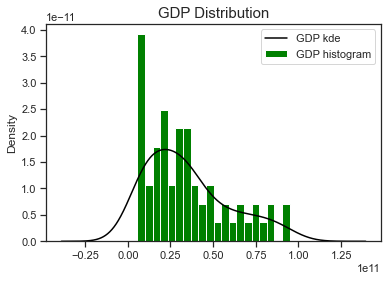

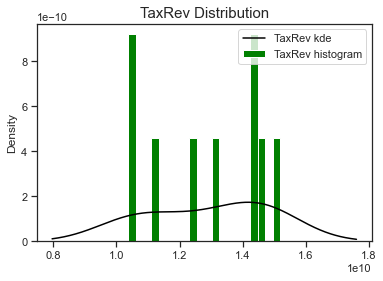

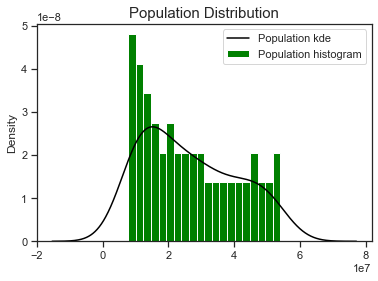

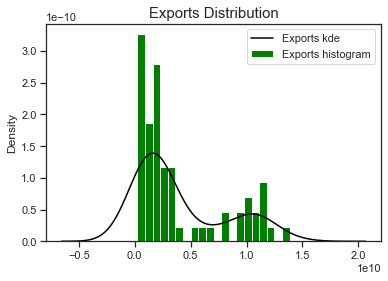

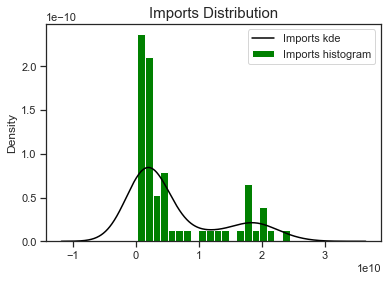

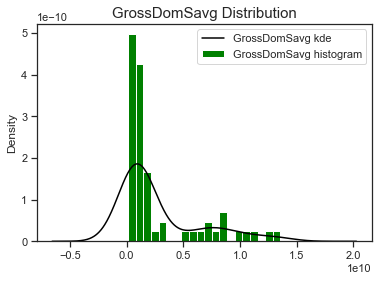

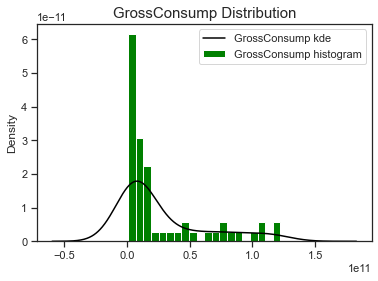

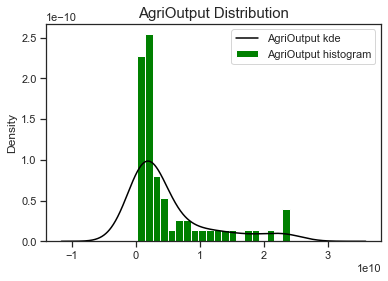

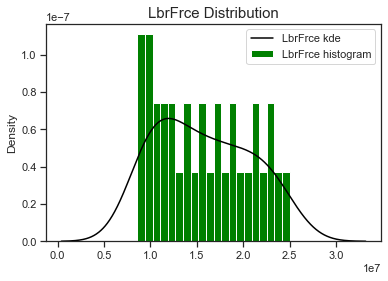

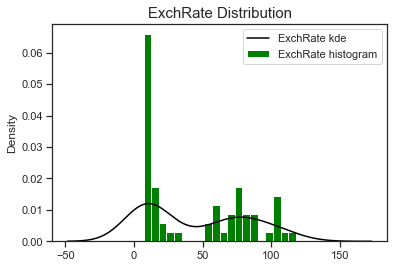

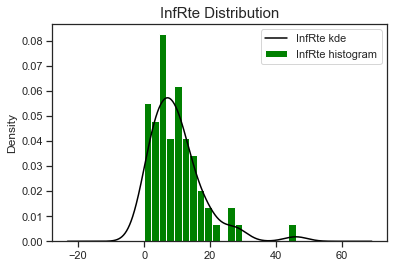

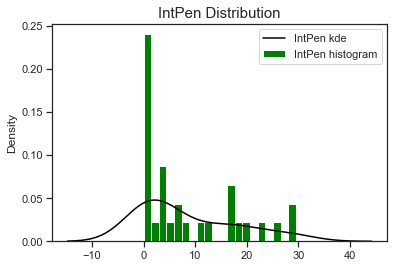

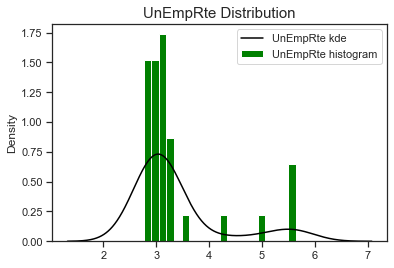

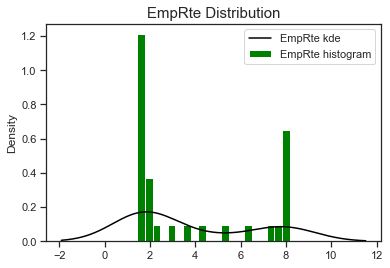

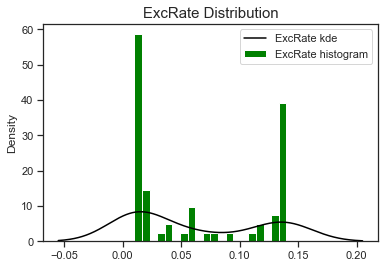

In [14]:
# For all the variables, check distribution by creating a histogram with kde
for column in df:
    df[column].plot.hist(density=True, bins=20, label = column+' histogram',color='green')
    df[column].plot.kde(label =column+' kde',color='black')
    plt.title(column+ ' Distribution', fontsize = 15)
    plt.legend()
    plt.show()

> **Variables follow a particular distribution - Non perfectly normal. Most varaibales positively skewed (Skewed to the right)**

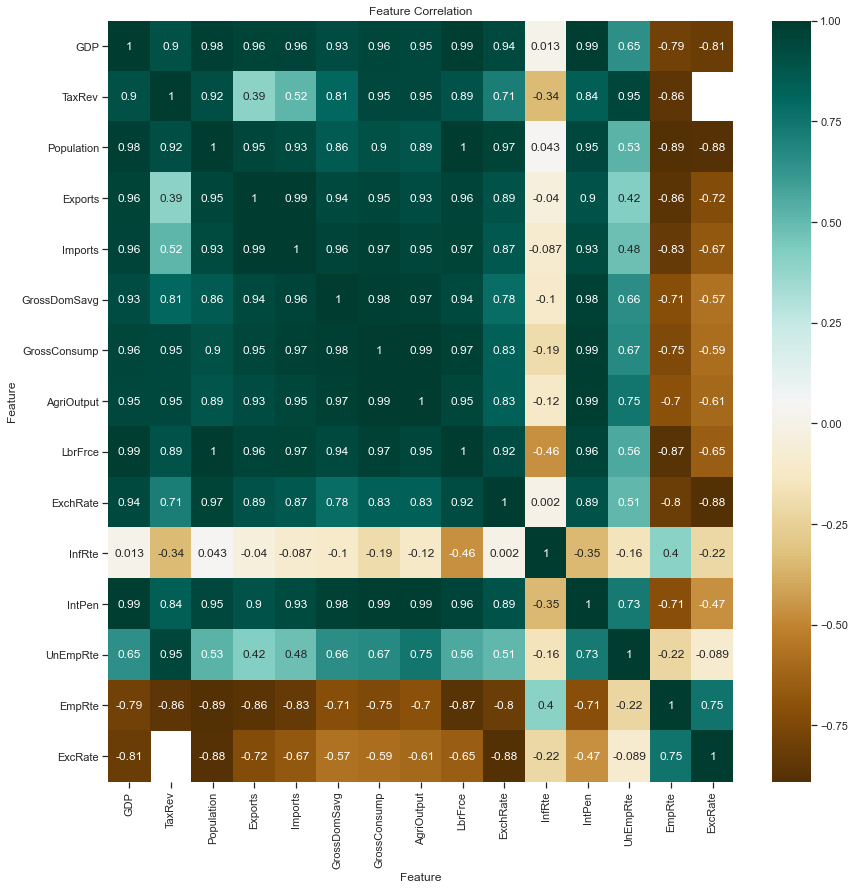

In [15]:
#Correlation heatmap
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(scaled_df.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Feature', ylabel = 'Feature')
plt.show()

>**In the plot above, the dark green squares correspond to highly correlated features (>0.75). Darker brown segments corresponds to negatively correlated features (<-0.75).\
>The diagonal represents the correlation of a feature with itself, therefore the value is 1.\
>We can also see that there are a few features that are highly correlated.**

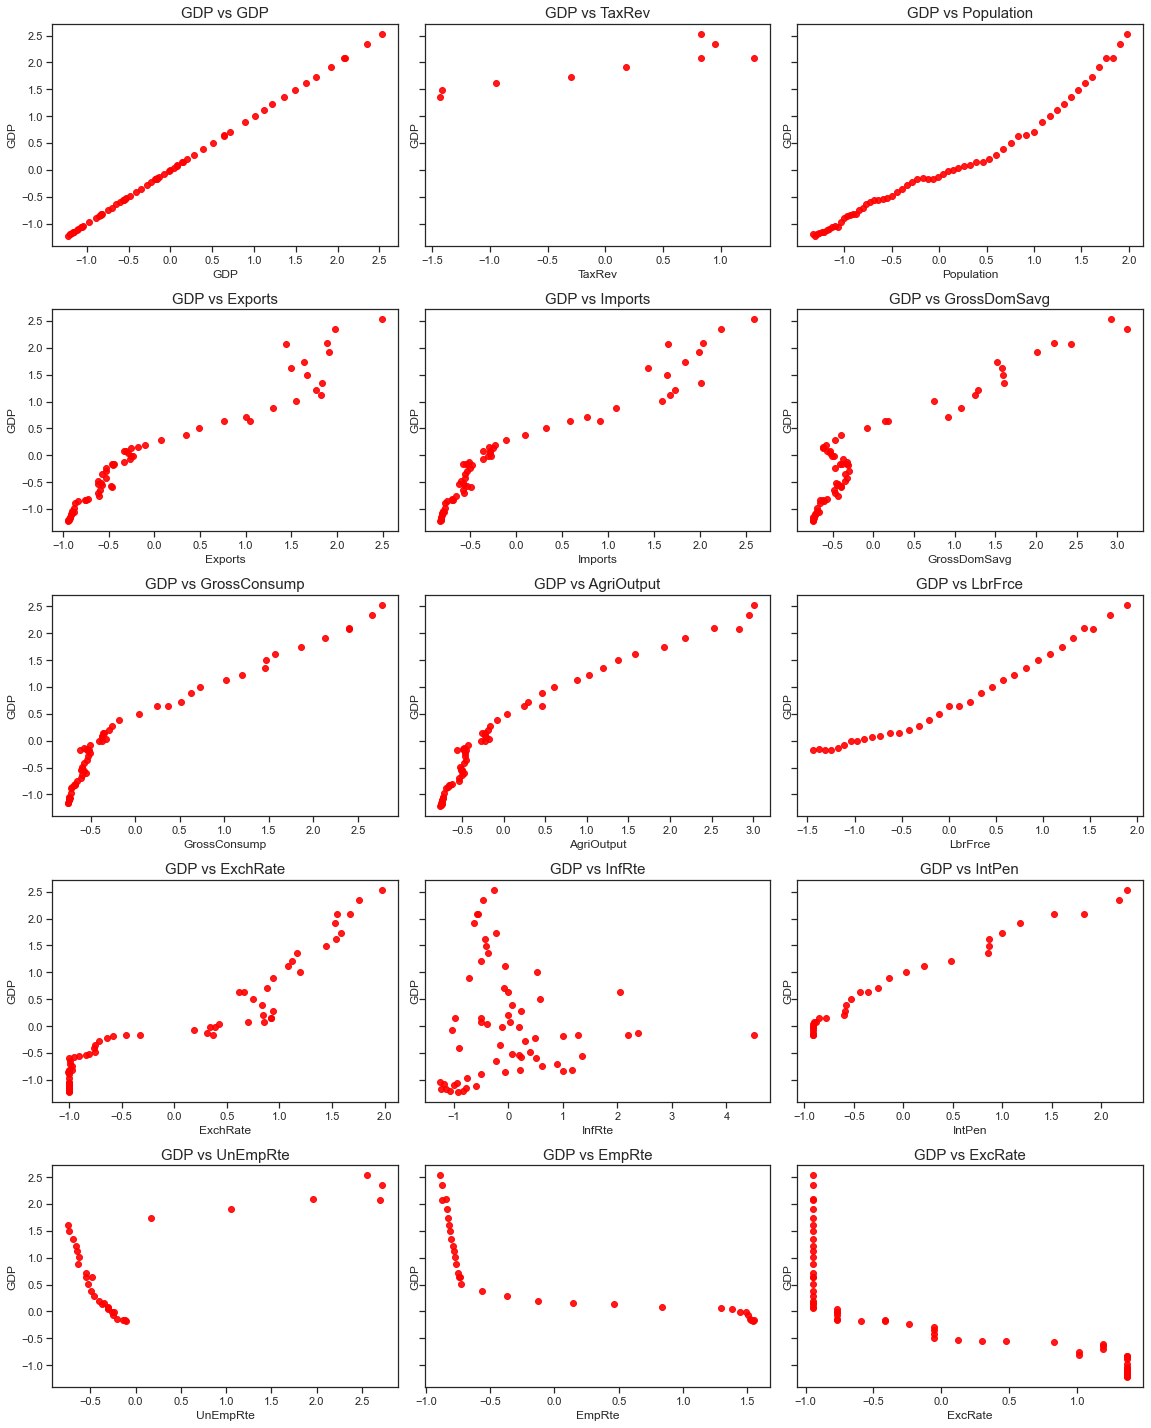

In [16]:
#Plotting subplots to visualize correlation between predictor & target variable
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16,20), sharey=True )
for ax, column in zip(axes.flatten(), scaled_df.columns):
    ax.scatter(scaled_df[column], scaled_df['GDP'], label=column, alpha=.9,color='red')
    ax.set_title(f'GDP vs {column}', fontsize=15)
    ax.set_xlabel(column)
    ax.set_ylabel('GDP')
fig.tight_layout()

> **GDP increasing over time with strong positive correlation with Population, Gross Consumption, Agriculture Output, Labor Force but a negative correlation noted with country's employment rate and exchange rate. Minimal/No correlation likewise noted with inflation rate**

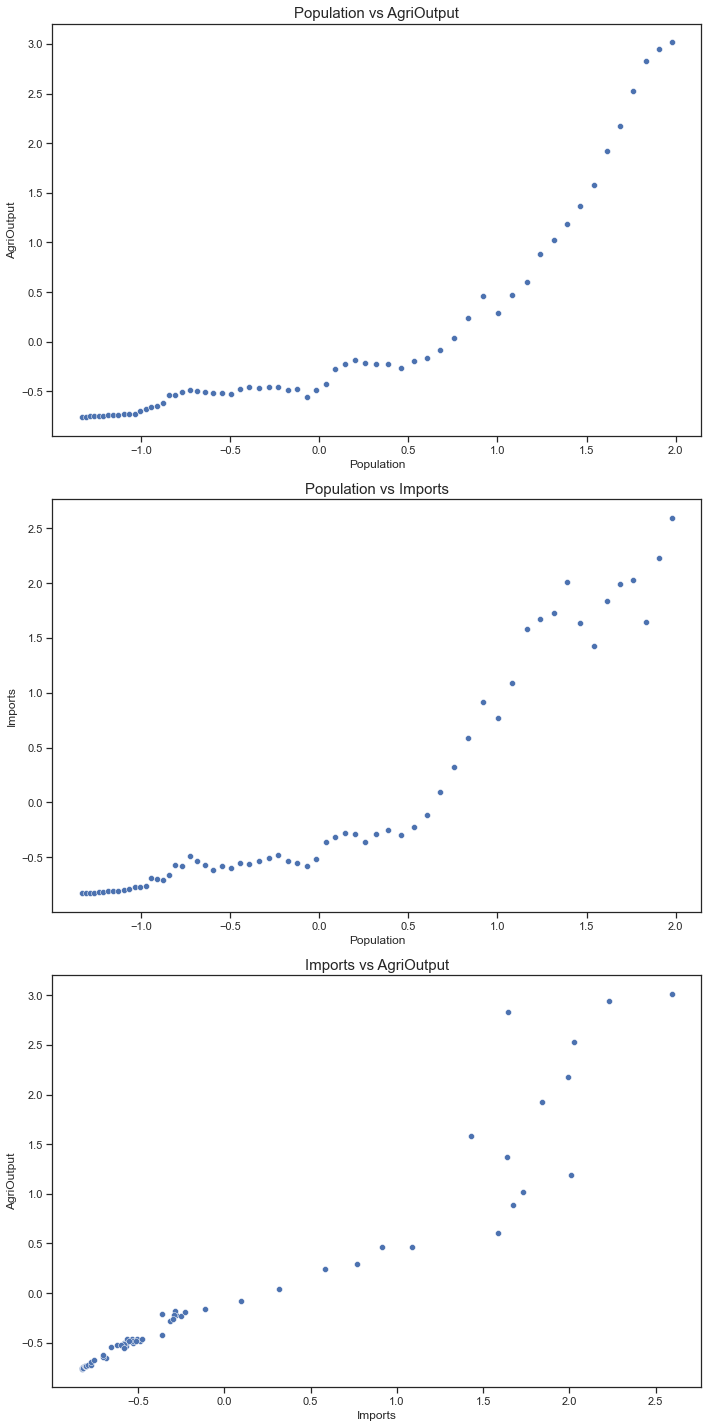

{('Population', 'AgriOutput'): 0.8858042267508428,
 ('Population', 'Imports'): 0.9269896988599481,
 ('Imports', 'AgriOutput'): 0.9485659699269929}

In [17]:
# Pair of variables for bivariate analysis
pairs = [('Population', 'AgriOutput'),
         ('Population', 'Imports'),
         ('Imports', 'AgriOutput')]

# Bivariate analysis
fig, axs = plt.subplots(nrows=3, figsize=(10, 20))

for i, pair in enumerate(pairs):
    sns.scatterplot(data=scaled_df, x=pair[0], y=pair[1], ax=axs[i])
    axs[i].set_title(f'{pair[0]} vs {pair[1]}', fontsize=15)

plt.tight_layout()
plt.show()

# Correlation coefficients
correlations = {pair: scaled_df[pair[0]].corr(scaled_df[pair[1]]) for pair in pairs}
correlations

> **Population vs AgriOutput:** The scatter plot shows a clear positive relationship between the population and the Agriculture Output. The correlation coefficient is approximately 0.89, indicating a very strong positive linear relationship. This implies that as the population increases, the agricultural output also tends to increase.

> **Population vs Imports:** The scatter plot shows a positive relationship between the population and Imports. The correlation coefficient is approximately 0.93, indicating a strong positive linear relationship. This suggests that as the population increases, imports also tends to increase.

> **Imports vs AgriOutput:** The scatter plot shows a positive relationship between the Imports and Agricultural Output. The correlation coefficient is approximately 0.95, indicating a strong positive linear relationship. This suggests that as the level of imports increases, Agricultural Outputs also tends to increase.

>**Please note that correlation does not imply causation. While these variables show strong positive correlations, it does not necessarily mean that an increase in one causes an increase in the other. Other factors might be influencing these relationships.**


**Detecting, Dealing & Visualizing Missing Values in our Dataset**

In [18]:
# Printing out the columns with missing values
[col for col in df.columns if df[col].isnull().any()]

['TaxRev', 'GrossConsump', 'LbrFrce', 'IntPen', 'UnEmpRte', 'EmpRte']

In [19]:
#Creating Function Returning Missing Values Table

def missing_values_table(df):
    mis_val = df.isnull().sum() #Total Missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df) #%ge of missing values
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) #creating missing values table
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #Rename columns
    mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1) # Sort table by %ge of missing descending
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.") #Print out Info

    return mis_val_table_ren_columns #Return the dataframe with missing information

In [20]:
#Missing Values dataframe
missing_df = missing_values_table(df)
missing_df

Your selected dataframe has 15 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
TaxRev,54,85.7
IntPen,32,50.8
UnEmpRte,31,49.2
EmpRte,31,49.2
LbrFrce,30,47.6
GrossConsump,4,6.3


> **Nil missing values detected on our target variable (GDP)**

<AxesSubplot:>

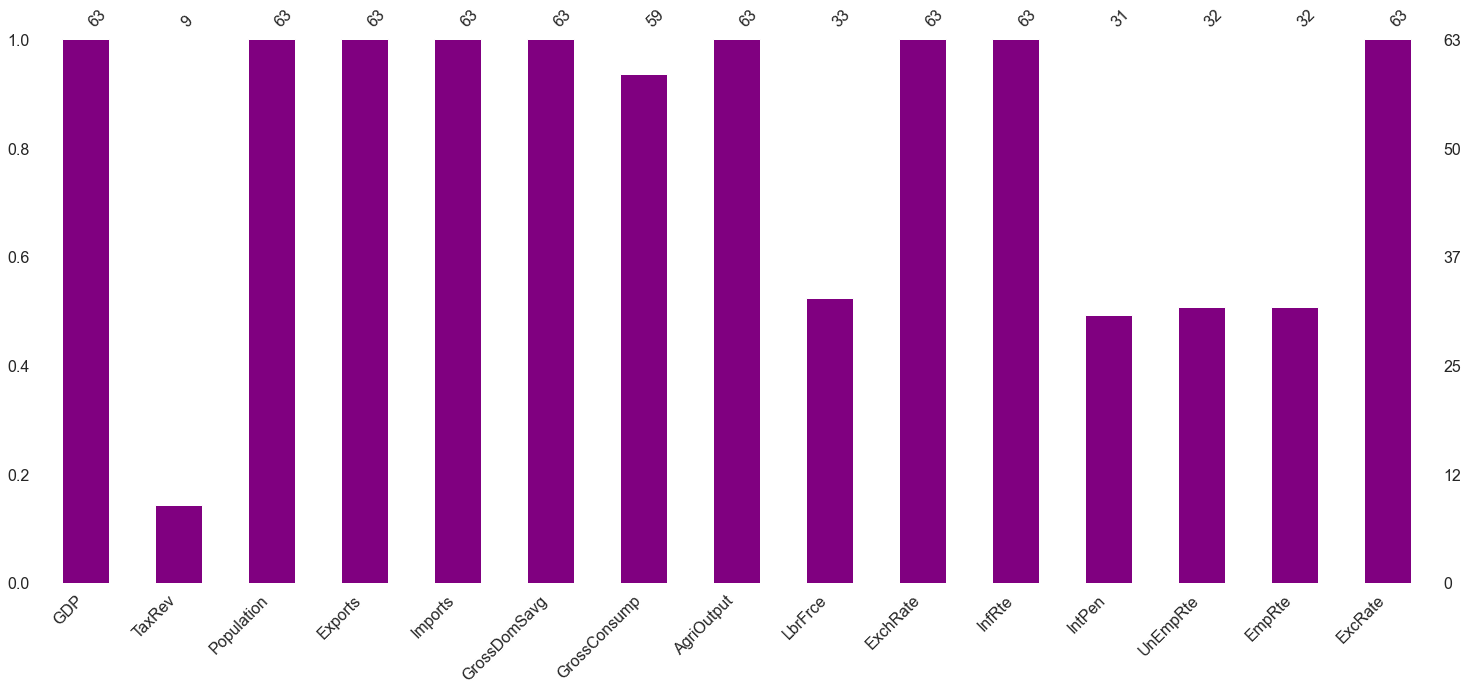

In [21]:
#Visualizing Missing Values using bar plot
msno.bar(df, color = 'purple')

> Here you can immediately see that the `TaxRev`,`UnEmpRte`, `EmpRte`,`IntPen` features have considerable amounts of missing values while `GrossConsump` has few missing values.

<AxesSubplot:>

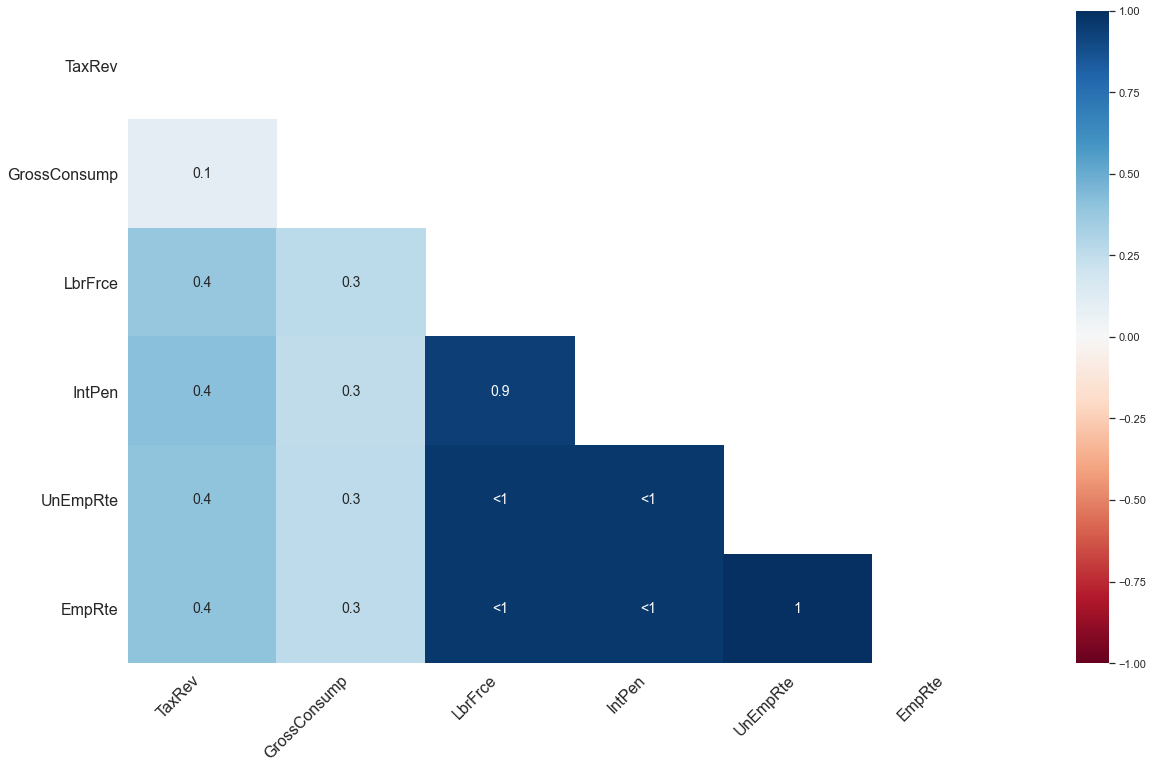

In [22]:
# Gives a heatmap of how missing values are related
msno.heatmap(df)

> **Perfect correlation between `UnEmpRte~EmpRte` & `LbrFrce~IntPen` feature pairs\
> There are no strong correlations between other missing values of different features**

It's worth noting that Kenya Revenue Authority (KRA), an agency of the Government of Kenya responsible for the assessment, collection and accounting of all revenues became effective on 1 July 1995, thus getting past data is a challenge. We shall proceed to replace missing vallues under this column with zero because dropping entire row with missing values shall lead to substansial loss of our target variables data. (GDP data)

Dropping missing rows from tax revenue column leads to loss of 53 entries (84% of our data points) thus the choice of retaining the column & filling the missing values with zero.

Filling missing values of predictor variables with zero due to data unavailability for past periods and proceeding to perform feature importance. (Most columns missing data dated pre-2013).

In [23]:
df.fillna(value=0, inplace=True)

In [24]:
missing_df_1=missing_values_table(df)

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


**Feature Importance**: technique that calculate a score for all the features for our dataset — the scores represent the “importance” of each feature. A higher score means that the specific feature will have a larger effect on the model that is being used to predict our target variable. This shall assist us to: **`Better understanding our data and model and to Reduce the number of input features.`**

In [25]:
#setting our X and y variables
X = df.drop(['GDP'], axis = 1) #predictors
y = df['GDP'] #target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #performing train & test split
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

Linear Regression Feature Importance

In [26]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': linreg.coef_
    })
importances = importances.sort_values(by='Importance', ascending=False)
print(linreg.coef_)

# visualization
plt.figure(figsize=(15,8))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances: Linear Regression', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Accuracy Test
print(f"Model train accuracy: {linreg.score(X_train_scaled, y_train):.3f}")
print(f"Model test accuracy: {linreg.score(X_test_scaled, y_test):.3f}")

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

>**The model is slightly overfitting on both the training & test data. We shall try reduce the overfitting by running other models before decing on which to settle on.**

Decision Tree Feature Importance

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
print(dt.feature_importances_)

# visualization
plt.figure(figsize=(15,8))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='blue')
plt.title('Feature importances: Decision Tree', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Accuracy Test
print(f"Model train accuracy: {dt.score(X_train_scaled, y_train):.3f}")
print(f"Model test accuracy: {dt.score(X_test_scaled, y_test):.3f}")

> **The model is overfitting on the training data but still has no decent performance on the testing set**

Random Forest Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)
print(rf.feature_importances_)

# visualization
plt.figure(figsize=(15,8))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='red')
plt.title('Feature importances: Random Forest', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Accuracy Test
print(f"Model train accuracy: {rf.score(X_train_scaled, y_train):.3f}")
print(f"Model test accuracy: {rf.score(X_test_scaled, y_test):.3f}")

> **Model slightly fixes the overfitting as the feature importances calculated on the training and the testing set look much similar to each other. This gives us more confidence that a robust model gives accurate model importances.**

**Time Series Analysis**

In [ ]:
#Checking trends of predictor varioables & top predictors
trends = df[['GDP','Population','Imports','AgriOutput']]

In [ ]:
#Scaling data set
scaler = StandardScaler()
scaled_trends = scaler.fit_transform(trends)
scaled_trends_df = pd.DataFrame(scaled_trends, columns = trends.columns)

In [ ]:
scaled_trends_df.plot(figsize=(15,8))
plt.title('Trend Analysis: GDP vs Top Predictors', fontsize=20)
plt.ylabel('US$', fontsize=14)
plt.xlabel('Year', fontsize=14);

In [ ]:
scaled_trends_df.corr()

In [ ]:
trends_diff = scaled_trends_df.diff(periods=1)

In [ ]:
trends_diff.plot(figsize=(15,8))
plt.title('Differenced Trend Analysis: Lag 1', fontsize=20)
plt.xlabel('Year', fontsize=14);

In [ ]:
trends_diff.corr()

Focusing predicting our target series (GDP)

In [ ]:
#identifying components of out time series (GDP)
data = df['GDP']

Visualizing timeseries data: Plotting line plot to assist get a sense of how our time series dataset changes over time.

In [ ]:
#Line plot to visualize trend
data.plot(figsize = (15,6), linewidth=2, fontsize=14)
plt.ylabel('US$', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.title('Trend Analysis', fontsize=20)
plt.show();

**Time Series Decomposition**: Decompose our time series into 3 distinct components: **`Trend, Seasonality & Residual(Noise)`**; making it easier to quickly identify changing mean or variation our time series.

In [ ]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(data))

# Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(15,8))
plt.subplot(411)
plt.plot(data, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

> **The plot above clearly shows that GDP is stable (upward trend), along with no visible seasonality/residuals (Nature of data points `(missing intra year datapoints)` does not allow for seasonality/residuals).**

**Time Series Stationarity Check**

Stationarity is an important assumption for time series models, as it ensures that the statistical properties of the data remain constant over time. We will also check for stationarity using the Augmented Dickey-Fuller (ADF) test:

Below function `stationarity_check()` takes in a time series and performs stationarity checks including rolling statistics and the **Dickey-Fuller test** (Stationarity Test).

The ADF test tests the null hypothesis that the time series data is non-stationary. If the p-value is less than 0.05, we can reject the null hypothesis and conclude that the data is stationary.

In [ ]:
def stationarity_check(data):

    # Import adfuller
    from statsmodels.tsa.stattools import adfuller

    # Calculate rolling statistics
    roll_mean = data.rolling(window=8, center=False).mean()
    roll_std = data.rolling(window=8, center=False).std()

    # Perform the Dickey Fuller Test
    dftest = adfuller(data)

    # Plot rolling statistics:
    fig = plt.figure(figsize=(15,8))
    plt.plot(data, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block=False)

    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    return None

# HO (Null Hypothesis): Series NOT Stationary
# H1 (Alternate Hypothesis): Series IS Stationary
# pvalue > 0.05 - Fail to Reject H0
# pvalue < 0.05 - Accept H1

Using Function check_stationarity() to see if our series is stationary!

In [ ]:
stationarity_check(data)

> **Pvalue >0.05 & Test Statistic also greater than critical value (5%); We Fail to Reject Null Hypothesis;\
Time series NOT Stationary**

Differencing

In [ ]:
# Difference our data
diff_1 = data.diff(periods=1)

# Drop the missing values
diff_1.dropna(inplace=True)

# Performing the stationarity check
stationarity_check(diff_1)

> **Time series NOT Stationary; pvalue > 0.05**

We shall look into other techniques of making our time series stationary


**Performing log and square root transform**

In [ ]:
# log transform
data_log = np.log(data)

# Square root transform
data_sqrt = np.sqrt(data)

# Subtracting rolling mean, with time window of 7
roll_mean = np.log(data).rolling(window=7).mean()

# Subtract the moving average from the log transformed data
data_minus_roll_mean = np.log(data) - roll_mean

# Dropping the missing values from dataset
data_minus_roll_mean.dropna(inplace=True)

# Performing stationarity Check
stationarity_check(data_minus_roll_mean)

> **Pvalue >0.05 & Test Statistic also greater than critical value (5%); We Fail to Reject Null Hypothesis;\
Time Series NOT Stationary**

**Subtracting the weighted rolling mean**. Repeating all the above steps to calculate the exponential weighted rolling mean with a halflife of 4. Starting from the log-transformed data again & comparing the Dickey-Fuller test results.

In [ ]:
# Calculate Weighted Moving Average of log transformed data
exp_roll_mean = np.log(data).ewm(halflife=4).mean()

# Subtract the exponential weighted rolling mean from the original data
data_minus_exp_roll_mean =  np.log(data) - exp_roll_mean

# Performing stationarity check
stationarity_check(data_minus_exp_roll_mean)

> **Pvalue >0.05 & Test Statistic also greater than critical value (5%); We Fail to Reject Null Hypothesis;\
Time Series NOT Stationary**

**Differencing**: Using exponentially weighted moving averages, we seem to have removed some trend. Next we shall use differencing to further remove/reduce seasonality/trends.

In [ ]:
# Difference our data
data_diff = data_minus_exp_roll_mean.diff(periods=12)

# Drop the missing values
data_diff.dropna(inplace=True)

# Performing the stationarity check
stationarity_check(data_diff)

>***Here you can evaluate the test statistic which is smaller than the critical value(5%) and also the p-value is very much less than the significant value 0.05%. Thus rejecting the null hypothesis and considering the data as STATIONARY.***

> **Time Series now ready for Modelling**

**Plotting Auto-Correlation (ACF) & Partial Autocorrelation (PACF) Plots**

The autocorrelation plot shows the correlation between the time series and its lagged values. The partial autocorrelation plot shows the partial correlation between the time series and its lagged values, after removing the effect of intermediate lags.

> ***If the autocorrelation plot shows a significant correlation at lag 1 and the partial autocorrelation plot shows a sharp drop at lag 1, it suggests that the time series is stationary. If the autocorrelation plot shows a slow decay and the partial autocorrelation plot shows significant correlations at multiple lags, it suggests that the time series is not stationary and may require differencing.***

In [ ]:
# Plotting ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 15, 8

plot_acf(data_diff, lags=20);

plot_pacf(data_diff, lags=24);

> **Here to get our q value for moving averages we will see at what point does graph cuts significance line, it cuts negatively at 0 and positively at 1 so q = 0 or q = 1 both are fine**

> **From above visualization, we can deduce that the previous GDP value influences the current GDP value, bit the significance of that influence decreases and increases with regular time intervals.**

Based on the ACF and PACF, we shall proceed to fit an ARMA model with the right orders for AR and MA. We shall try different models and compare AIC and BIC values, as well as significance values for the parameter estimates.

## Modelling, Prediction & Evaluation

For **Evaluating** the performance of our chosen model, we can use the following accuracy metrics:

**Mean Squared Error (MSE)**: It measures the average squared difference between the actual and predicted values. The lower the MSE, the better the model's performance.

**Root Mean Squared Error (RMSE)**: It is the square root of the MSE and gives us an idea of how much the predictions deviate from the actual values in the same unit as the target variable.

**Mean Absolute Error (MAE)**: It measures the average absolute difference between the actual and predicted values. It is less sensitive to outliers compared to MSE and RMSE.

**Mean Absolute Percentage Error (MAPE)**: It measures the average percentage difference between the actual and predicted values. It is a relative measure and can be used to compare the performance of models on datasets with different scales.

> For this project, we shall use both the **MSE & MAE** to score our models

### Auto-Regressive Model

The equation for the AR model (**Yt = C + b1 Yt-1 + b2 Yt-2+……+ bp Yt-p + Ert**)\
Where: p denotes past values; Yt functions of different past values; Ert Errors in time; C intercept

Fitting model and making predictions for future values

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import datetime

autoreg = AutoReg(data_diff, lags=20) # Instantiate model
autoreg_fit = autoreg.fit() # Fit Model
print(autoreg_fit.summary()) # Print summary

# predict
start_index = datetime(2019, 12, 31)
end_index = datetime(2027, 12, 31)
forecast = autoreg_fit.predict(start=start_index, end=end_index)
print(forecast)

# visualization
plt.figure(figsize=(15,8))
plt.plot(data_diff.index,data_diff,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("AR Model Forecast Visualization",fontsize=20)
plt.xlabel("YEAR",fontsize=15)
plt.ylabel("GDP",fontsize=15)
plt.legend()
plt.show()

Checking accuracy of our model

In [ ]:
predictions = autoreg_fit.predict(start=len(data_diff), end=len(data_diff)+len(data_diff)-1, dynamic=False) # Predictions
mse = mean_squared_error(data_diff, predictions) # MSE score
mae = mean_absolute_error(data_diff, predictions) # MAE score

print('MSE: %.3f' % mse)
print('MAE: %.3f' % mae)

# Plot actual and predicted values
fig= plt.subplots(figsize=(15,8))
plt.plot(data_diff.index, data_diff, label='Actual')
plt.plot(data_diff.index, predictions, label='Predicted')
plt.title("AR Model: Actual vs Predicted",fontsize=20)
plt.xlabel("YEAR",fontsize=15)
plt.ylabel("GDP",fontsize=15)
plt.legend()
plt.show()

### ARIMA Model (AutoRegressive Integrated Moving Average)

Time series forecasting model that uses the past values of a time series to predict the future values. ARIMA model has three parameters (p, d, q), where p is the order of the autoregressive (AR) term, d is the degree of differencing required to make the time series stationary, and q is the order of the moving average (MA) term.

Formula: (**AR + I + MA = ARIMA**);\
Where **AR** Uses past values to predict the future; **I** Uses the differencing of observation and makes the stationary data & **MA** Uses past error terms in the given series to predict the future

In [ ]:
# fitting a simple model with p=1, d=1, and q=1:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pandas import datetime

model = ARIMA(data_diff, order=(1,1,1)) # Instantiate model
model_fit = model.fit() # fit model
print(model_fit.summary()) # print summary

> The summary of the model fit gives us information about the coefficients of the model, as well as goodness-of-fit statistics like the AIC and BIC. From the summary, we can see that the coefficient for the AR(1) term is significant, as is the coefficient for the MA(1) term. We can also see that the AIC and BIC values are relatively low, which suggests that the model fits the data well.

We can now use the fitted model to make **predictions** for future values of the time series:

In [ ]:
# predict
start_index = datetime(2017, 12, 31)
end_index = datetime(2040, 12, 31)
forecast = model_fit.predict(start=start_index, end=end_index)
print(forecast)

# visualization
plt.figure(figsize=(15,8))
plt.plot(data_diff.index,data_diff,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("ARIMA Model Forecast Visualization",fontsize=20)
plt.xlabel("YEAR",fontsize=15)
plt.ylabel("GDP",fontsize=15)
plt.legend()
plt.show()

In [ ]:
# making predictions
predictions = model_fit.predict(steps=len(data_diff))
predictions.tail()

In [ ]:
# Calculate accuracy metrics
mse = mean_squared_error(data_diff, predictions)
mae = mean_absolute_error(data_diff, predictions)

# Print accuracy metrics
print('MSE: %.3f' % mse)
print('MAE: %.3f' % mae)

In [ ]:
# Plot actual and predicted values
fig= plt.subplots(figsize=(15,8))
plt.plot(data_diff.index, data_diff, label='Actual')
plt.plot(data_diff.index, predictions, label='Predicted')
plt.title("ARIMA Model (1,1,1): Actual vs Predicted",fontsize=20)
plt.xlabel("YEAR",fontsize=15)
plt.ylabel("GDP",fontsize=15)
plt.legend()
plt.show()

> **Lower MSE & MAE score: Model Performs better than AR model**

### SARIMA Model

Optimal parameter selection for the ARIMA Time Series Model.

The first step towards fitting an ARIMA model is to find the values of ARIMA(p,d,q)(P,D,Q)s that produce the desired output. Selection of these parameters requires domain expertise and time. We shall first generate small ranges of these parameters and use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels library and assess its overall quality.


In [ ]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)

# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_diff,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [ ]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC),
    SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

> **The output of our code suggests that ARIMA (1, 0, 1) x (0, 0, 0, 12) yields the lowest AIC value of -171.46. We should therefore consider this to be optimal option out of all the models we have considered.**

In [ ]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(data_diff,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

> **The model returns a lot of information, but we'll focus only on the table of coefficients. The coef column above shows the importance of each feature and how each one impacts the time series patterns. The  provides the significance of each feature weight.**

> **For our time-series, we see that each weight has a p-value lower than 0.05, so it is reasonable to retain all of them in our model.**

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated.

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

In [ ]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

* In the top right plot, we see that the orange KDE line follows closely with the N(0,1) green line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In order to validate the model, we start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.

**One-Step & Dynamic Forecasting**

In [ ]:
start_index = datetime(2000, 12, 31)

# One-step Ahead Forecasting
pred = results.get_prediction(start=start_index, dynamic=False)
pred_conf = pred.conf_int()

# Dynamic Forecasting
pred_dynamic = results.get_prediction(start=start_index, dynamic=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# ploting the above
ax = data_diff.plot(figsize=(15, 8))
pred.predicted_mean.plot(ax=ax, label='1-Step-Ahead Forecast')
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast')
plt.ylabel('GDP Levels')
plt.xlabel('Year')
plt.title("SARIMA Models: Actual vs Predicted",fontsize=20)
plt.legend()
plt.show()


One Step Forecasting

In [ ]:
start_index = datetime(2000, 12, 31)
# One-step Ahead Forecasting
pred = results.get_prediction(start=start_index, dynamic=False)
pred_conf = pred.conf_int()

# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 8

# Plot observed values
ax = data_diff.plot(label='observed')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
# Set axes labels
ax.set_xlabel('Year')
ax.set_title("SARIMA Model-One Step Forecasting: Actual vs Predicted",fontsize=20)
ax.set_ylabel('GDP Levels')
plt.legend()
plt.show()

In [ ]:
# Get the real and predicted values
GDP_forecasted = pred.predicted_mean
GDP_truth = data_diff['1990-01-01':]

# Compute the mean square error
mse = ((GDP_forecasted - GDP_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 5)))

> **The MSE of our one-step ahead forecasts yields a value of close to or equal to zero, which is very low. An MSE that is close to 0 indicates that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it is not typically possible.**

Dynamic Forecasting

In [ ]:
# Dynamic Forecasting
pred_dynamic = results.get_prediction(start=start_index, dynamic=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals as above
# Plot the dynamic forecast with confidence intervals.
ax = data_diff.plot(label='observed', figsize=(15, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)
ax.fill_betweenx(ax.get_ylim(), start_index, GDP_forecasted.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Year')
ax.set_title("SARIMA Model-Dynamic Forecasting: Actual vs Predicted",fontsize=20)
ax.set_ylabel('GDP Levels')
plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
GDP_forecasted = pred_dynamic.predicted_mean
GDP_truth = data_diff['1990-01-01':]

# Compute the mean square error
mse = ((GDP_forecasted - GDP_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 5)))

> The predicted values obtained from the dynamic forecasts yield an MSE of 0.0043. This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.

**Producing and Visualizing Forecasts**

We will now describe how to leverage our seasonal ARIMA time series model to forecast future values. The `.get_forecast()` method of our time series output can compute forecasted values for a specified number of steps ahead.

In [ ]:
# Get forecast 10 steps ahead in future
prediction = results.get_forecast(steps=10)
# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [ ]:
# Plot future predictions with confidence intervals
ax = data_diff.plot(label='observed', figsize=(15, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('Year')
ax.set_ylabel('GDP Levels')
ax.set_title("Preferred Model: Actual vs Predicted",fontsize=20)

plt.legend()
plt.show()

> Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

## Model Deployment

In [ ]:
!pip install streamlit

In [ ]:
# Importing Libraries
# creating and saving the app.py of the ARIMA model
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Function to load the ARIMA model
def load_arima_model():
    try:
        # Load the ARIMA model from file
        model = sm.load('arima_model.pkl')
        return model
    except FileNotFoundError:
        st.error("ARIMA model not found. Please make sure you have saved the model.")
        return None

# Function to load data_diff from CSV
def load_data_diff():
    try:
        data_diff = pd.read_csv('data_diff.csv')
        return data_diff
    except FileNotFoundError:
        st.error("data_diff.csv not found. Please make sure you have saved the file.")
        return None

# Function to make forecasts using the ARIMA model
def make_arima_forecasts(model, horizon):
    try:
        # Perform forecasts using the ARIMA model
        forecasts = model.forecast(steps=horizon)
        return forecasts
    except Exception as e:
        st.error(f"An error occurred while making forecasts: {str(e)}")
        return None

def main():
    st.title('ARIMA Time Series Forecasting')

    # Load the ARIMA model
    arima_model = load_arima_model()
    if arima_model is None:
        st.stop()

    # Load the data_diff
    data_diff = load_data_diff()
    if data_diff is None:
        st.stop()

    # Display the current data_diff
    st.subheader('Differenced Time Series Data')
    st.write(data_diff)  # Display the differenced time series data

    # Get user input for the forecasting horizon
    max_horizon = len(data_diff)  # Maximum allowed horizon is the length of the available data
    horizon = st.number_input('Enter the forecasting horizon:', value=10, min_value=1, max_value=max_horizon, step=1)

    # Make forecasts using the ARIMA model
    forecasts = make_arima_forecasts(arima_model, horizon)
    if forecasts is None:
        st.stop()

    # Create a DataFrame to display the forecasts
    last_date = data_diff.index[-1]
    forecast_dates = pd.date_range(start=last_date, periods=horizon + 1, closed='right')
    forecast_values = np.concatenate(([data_diff.iloc[-1]], forecasts))
    forecast_df = pd.DataFrame({'Forecast': forecast_values}, index=forecast_dates)

    # Display the forecasts as a graph
    st.subheader('ARIMA Forecasts')
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(data_diff.index, data_diff['Original'], label='Original Data')
    ax.plot(forecast_dates, forecast_values, label='Forecasts', linestyle='--', color='orange')
    ax.set_xlabel('Date')
    ax.set_ylabel('Differenced Value')
    ax.legend()
    st.pyplot(fig)

if __name__ == '__main__':
    main()

In [ ]:
# Running the application
!streamlit run app.py

## CONCLUSION

In this project, we used Kenya's statistics from world bank dataset to build a GDP predictor.

3 different learning regressors (Auto Regressive Model (AR), AutoRegressive Integrated Moving Average (ARIMA); and Seasonal ARIMA (SARIMA)) were tested, and we have acheived the best prediction performance using ARIMA model with least MSE score and less prone to overfitting.

An MSE that is close to 0 indicates that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it is not typically possible.

## LIMITATIONS

A clear limitation here is the size of the datasets and critical missing values (Tax Revenue Collections most affected column).